In [64]:
%matplotlib inline
import os
import re
import shutil
from time import time
from datetime import datetime
from tqdm import tqdm, tqdm_notebook
import math
import random
import collections
from mplfinance.original_flavor import candlestick2_ohlc
import warnings; warnings.filterwarnings("ignore")
from PIL import Image
from glob import glob

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib import image, font_manager, rc
import seaborn as sns

In [65]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.random.set_seed(415)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, Add, Multiply, Dot, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import get_custom_objects

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [66]:
tf.debugging.set_log_device_placement(True)

In [67]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [68]:
tf.config.experimental.set_memory_growth(gpus[0], True)

# Candidate of test

1. raw image
2. crop candle & volume
3. 1x1 vs 2x1
4. add meta data
5. image augment

* with Attention model
* predict future return rate and find can be attended point

## Crawl stock info

In [6]:
kospi = pd.read_csv('data/kospi_info.csv', index_col=False)
kosdaq = pd.read_csv('data/kosdaq_info.csv', index_col=False)

In [7]:
kospi_code = list(kospi['code'])
kosdaq_code = list(kosdaq['code'])

kospi_name = list(kospi['name'])
kosdaq_name = list(kosdaq['name'])

## Draw candle, volume charts

In [8]:
def draw_candle(data, code, i, d):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    index = data.index.astype('str')  # 캔들스틱 x축이 str로 들어감
    x = np.arange(len(data.index))
    candlestick2_ohlc(ax, data['open'][:-1], data['high'][:-1],
                      data['low'][:-1], data['close'][:-1],
                      width=0.6, colorup='tab:red', colordown='mediumblue', alpha=1)
    ax.axis('off')
    plt.tight_layout()
    fig.patch.set_visible(False)
    plt.savefig(f'./candle/{d}/{code}/{code}_{str(i).zfill(4)}.jpg', dpi=100)
    plt.close()
#     plt.grid()
#     plt.show()

In [9]:
def draw_volume(data, code, i, d):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    index = data.index.astype('str')  # 캔들스틱 x축이 str로 들어감
    x = np.arange(len(data.index))
    ax.bar(x, data.volume, color='k', width=0.6, align='center')
    ax.axis('off')
    plt.tight_layout()
    fig.patch.set_visible(False)
    plt.savefig(f'./volume/{d}/{code}/{code}_{str(i).zfill(4)}.jpg', dpi=100)
    plt.close()
#     plt.grid()
#     plt.show()

## Make seqeunce images - Kosdaq, Kospi

In [ ]:
for sample in tqdm(glob('./sample/*.csv')[376:]):
    code = re.findall('[A-Z0-9]+', sample)[0]
    data = pd.read_csv(sample, index_col=False)
    data.index = list(map(lambda x: datetime.strptime(str(x), '%Y%m%d').date(), data['date']))
    data.drop(columns=['date'], inplace=True)
   
    if data['dir'][-1] == 1:
        d = '1'
    else:
        d = '0'

    os.mkdir(f'candle/{d}/{code}')
    os.mkdir(f'volume/{d}/{code}')

    start = -100
    end = -70
    i = 0
    runs = -1
    
    try:
        while end < runs:
            draw_candle(data.iloc[start:end, :], code, i, d)
            draw_volume(data.iloc[start:end, :], code, i, d)

            i += 1
            start += 1
            end += 1
    except:
        pass

## Make video

In [60]:
# some global params
SIZE = (228, 228)
CHANNELS = 3
NBFRAME = 15
BS = 8

In [62]:
def make_video(file_path, c_type, d_type, code):
    img_array = []
    size=None
    for file in sorted(file_path):
        img = cv2.imread(file)
        h, w, d = img.shape
        size = (w, h)
        img_array.append(img)

    video = cv2.VideoWriter(f'./{c_type}/{d_type}/{code}.avi', cv2.VideoWriter_fourcc(*'DIVX'), NBFRAME, size)

    for i in range(len(img_array)):
        video.write(img_array[i])
    video.release()

In [63]:
chart_type = ['candle', 'volume']
dir_type = ['1', '0']

for c_type in tqdm_notebook(chart_type, desc='Chart type', ):
    for d_type in tqdm_notebook(dir_type, desc='Direction', ):
        code_list = os.listdir(os.path.join(c_type, d_type))
        for code in tqdm(code_list):
            file_path = glob(os.path.join(c_type, d_type, code)+'/*.jpg')
            make_video(file_path, c_type, d_type, code)

100%|██████████| 943/943 [08:27<00:00,  1.86it/s]

100%|██████████| 943/943 [08:01<00:00,  1.96it/s]

# Set video generator

In [12]:
from keras_video import VideoFrameGenerator
import keras_video.utils

Using TensorFlow backend.


In [69]:
# some global params
SIZE = (228, 228)
CHANNELS = 3
NBFRAME = 15
BS = 8

In [70]:
classes = [i.split(os.path.sep)[1] for i in glob('candle/*')]
classes.sort()

In [71]:
# pattern to get videos and classes
candle_pattern = './candle/{classname}/*.avi'
volume_pattern = './volume/{classname}/*.avi'

In [72]:
# Create candle video frame generator
train_candle = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=candle_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class 0, validation count: 154, train count: 314
class 1, validation count: 98, train count: 200
Total data: 2 classes for 514 files for train


In [73]:
valid_candle = train_candle.get_validation_generator()

Total data: 2 classes for 252 files for validation


Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


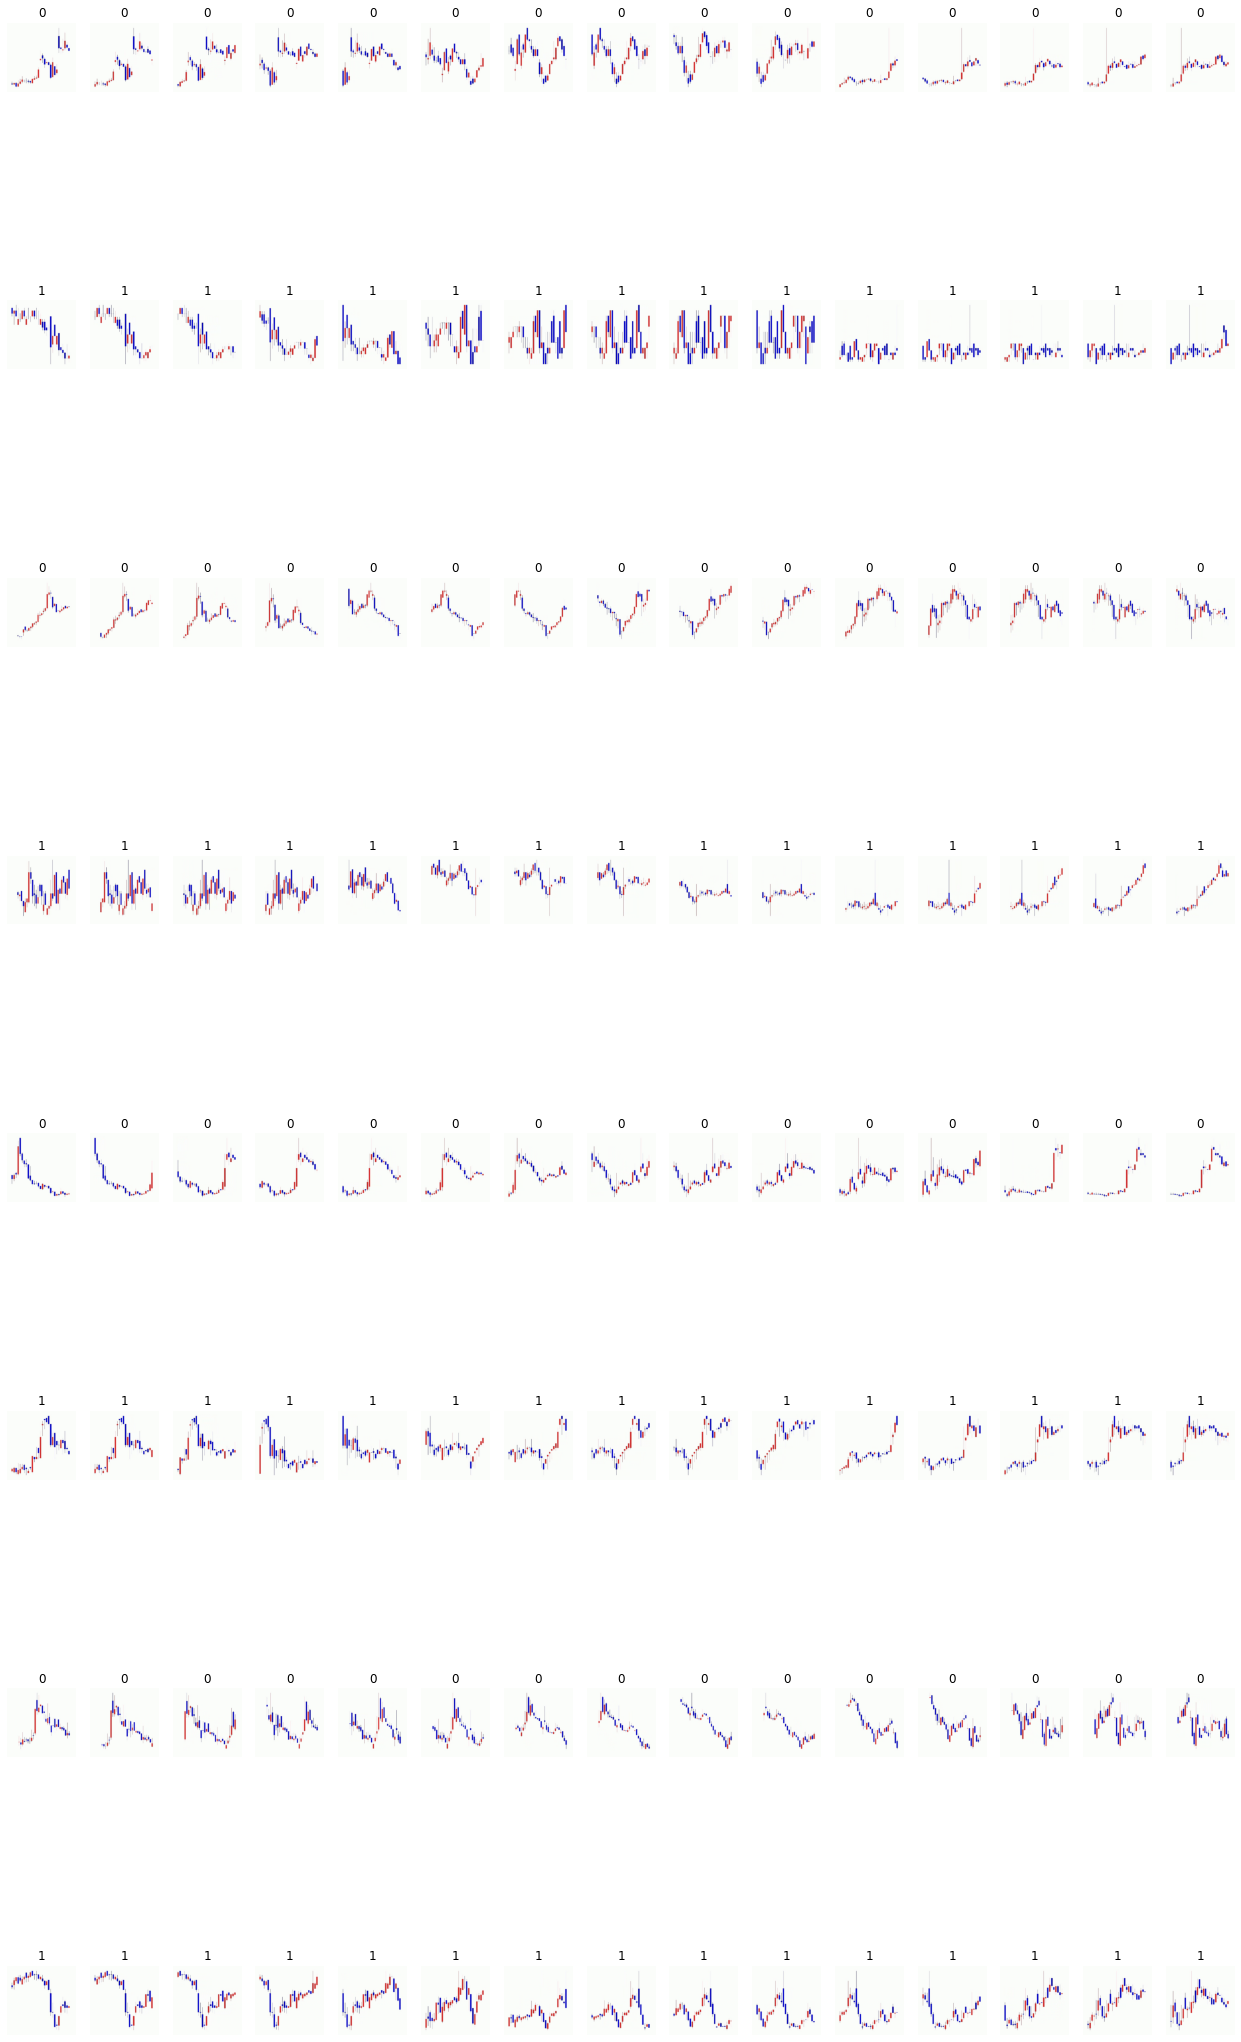

In [74]:
keras_video.utils.show_sample(train_candle)

In [75]:
# Create candle video frame generator
train_volume = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=volume_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class 0, validation count: 154, train count: 314
class 1, validation count: 98, train count: 200
Total data: 2 classes for 514 files for train


In [76]:
valid_volume = train_volume.get_validation_generator()

Total data: 2 classes for 252 files for validation


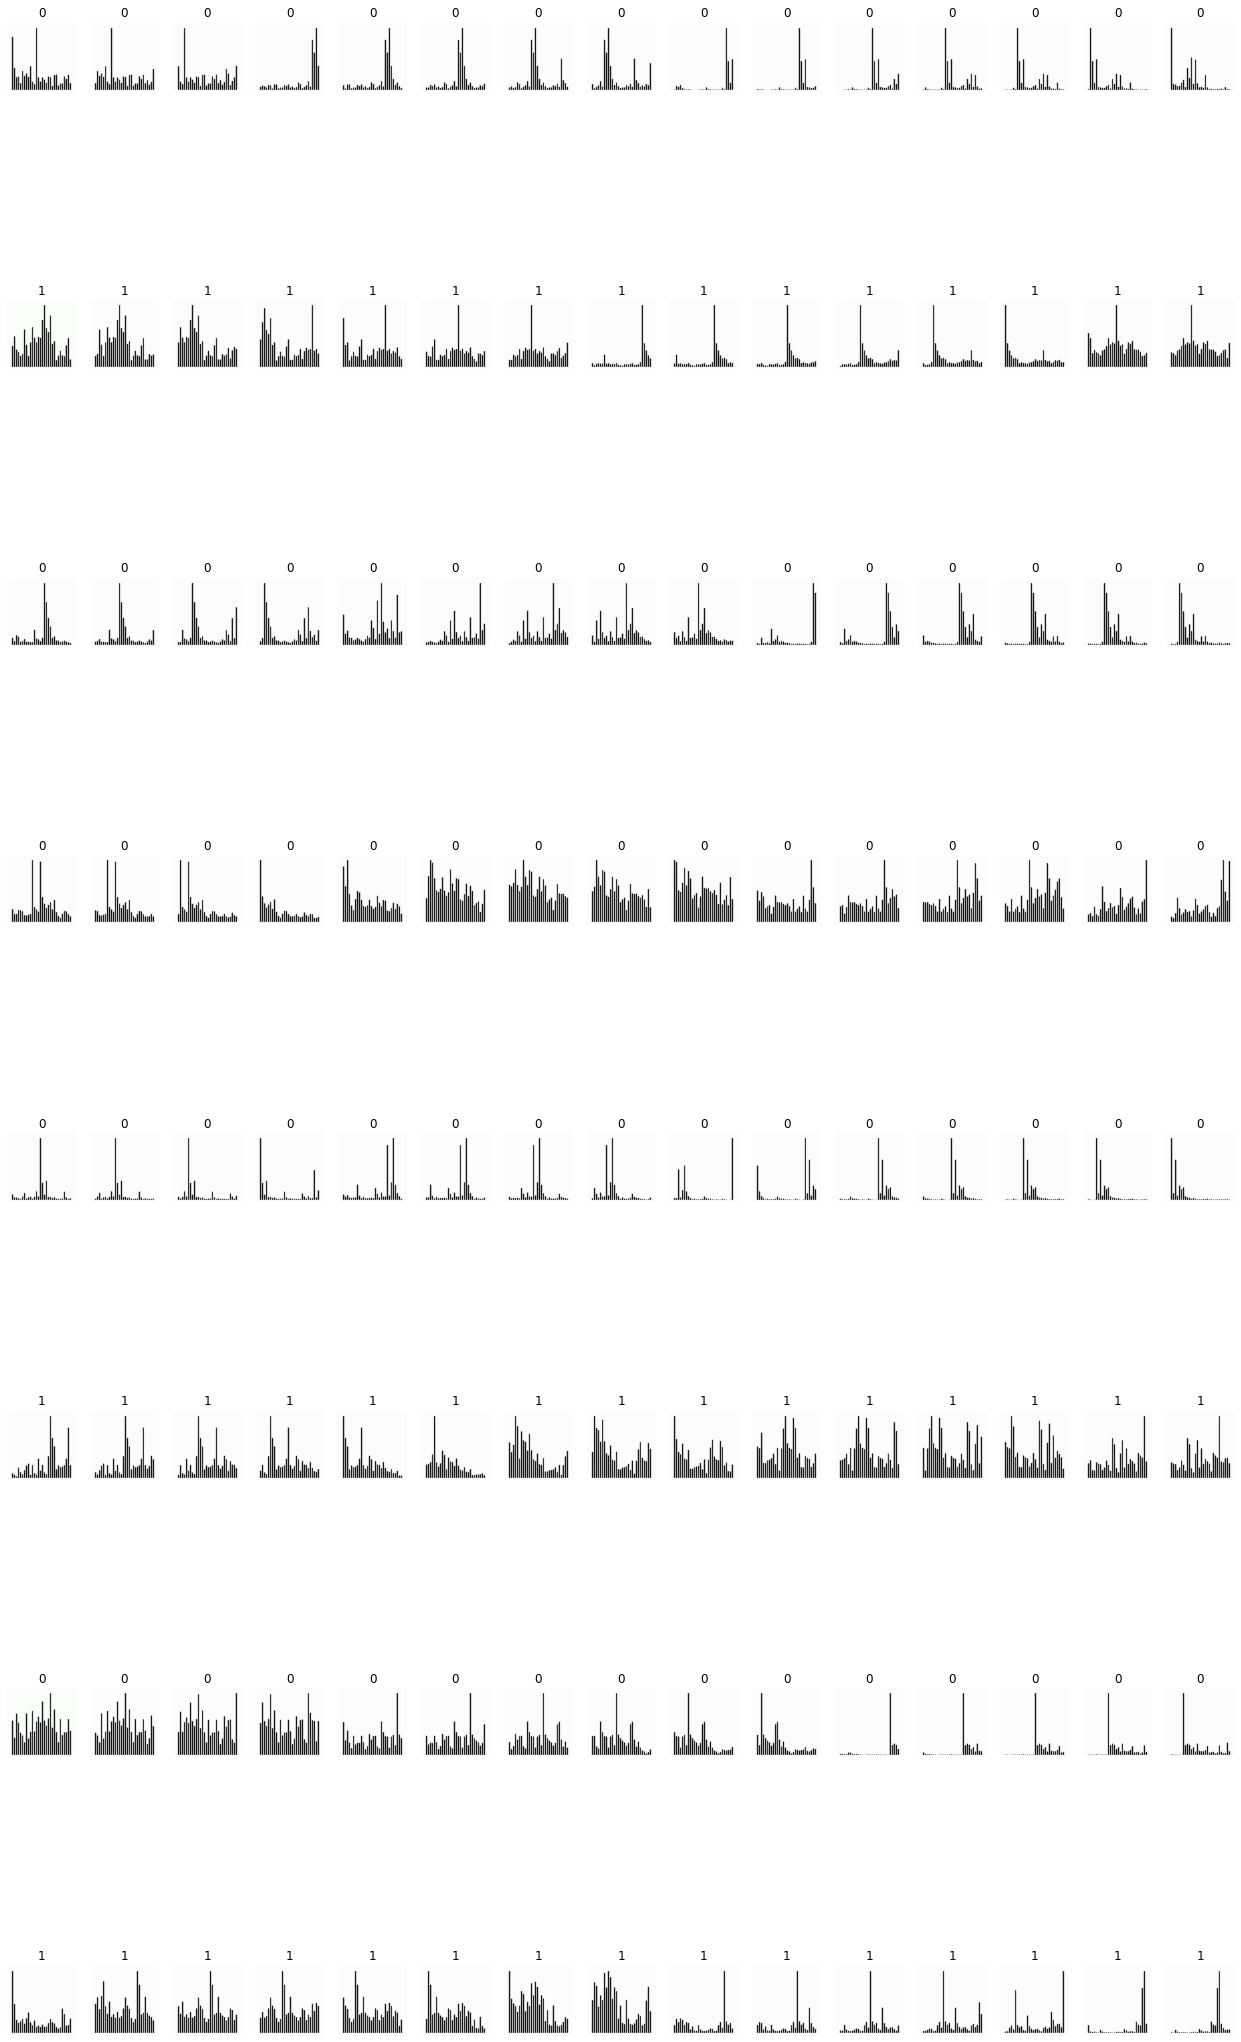

In [77]:
keras_video.utils.show_sample(train_volume)

## Base Model with Time Distributed

In [45]:
def build_convnet(shape=(228, 228, 3)):
    momentum = .9
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    model.add(GlobalMaxPooling2D())
    return model

In [46]:
def action_model(shape=(NBFRAME, 228, 228, 3), nbout=None):
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = tf.keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    model.add(GRU(64))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [47]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)

In [48]:
td_model = action_model(INSHAPE, len(classes))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform i

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 4, 512)            4689216   
_________________________________________________________________
gru (GRU)                    (None, 64)                110976    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

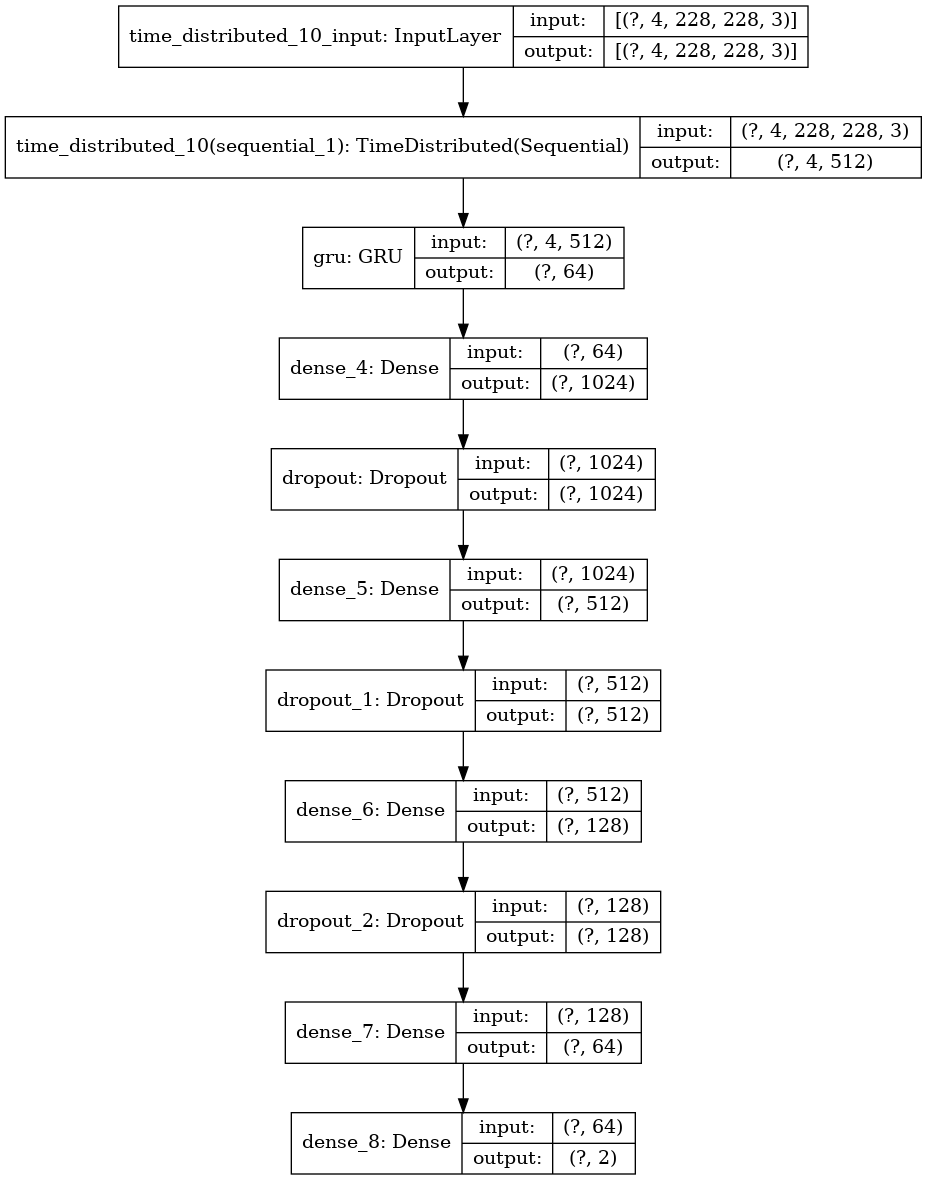

In [50]:
td_model.summary()
plot_model(td_model, show_shapes=True)

In [52]:
td_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [55]:
history = td_model.fit_generator(
    train_candle,
    validation_data=valid_candle,
    verbose=1,
    epochs=10,
    callbacks=[TensorBoard(log_dir="../logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "td_model")
               ModelCheckpoint(
                   filepath = './checkpoint', save_weights_only = True, 
                   monitor = 'var_accuracy', 
                   mode = 'max',
                   save_best_only = True), 
               EarlyStopping(monitor = 'loss', patience = 3)]
)

  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_7126 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignAddVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
      1/Unknown - 6s 6s/step - loss: 0.6622 - accuracy: 0.6250Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
  58830/Unknown - 18941s 322ms/step - loss: 0.6271 - accuracy: 0.6542Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:local

KeyboardInterrupt: 

### note

1. 학습이 말도안되게 너무 오래걸림

## Advanced Model with Time Distributed

In [ ]:
with tf.device('/gpu:0'):
    candle_input = Input(shape=(NBFRAME, 228, 228, 3))
    volume_input = Input(shape=(NBFRAME, 228, 228, 3))

    td_conv2d_c = TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu'),
        input_shape=(NBFRAME, 228, 228, 3))(candle_input)
    td_conv2d_c = TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu'))(td_conv2d_c)
    td_conv2d_c = TimeDistributed(MaxPooling2D((2,2), strides=(2,2)))(td_conv2d_c)
    td_conv2d_c = TimeDistributed(Conv2D(128, (3,3), strides=(2,2)))(td_conv2d_c)
    td_conv2d_c = TimeDistributed(GlobalMaxPooling2D())(td_conv2d_c)

    lstm_c = LSTM(1024, activation='relu', return_sequences=False)(td_conv2d_c)


    td_conv2d_v = TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu'),
        input_shape=(NBFRAME, 228, 228, 3))(volume_input)

    td_conv2d_v = TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu'))(td_conv2d_v)

    td_conv2d_v = TimeDistributed(MaxPooling2D((2,2), strides=(2,2)))(td_conv2d_v)

    td_conv2d_v = TimeDistributed(Conv2D(128, (3,3), strides=(2,2)))(td_conv2d_v)

    td_conv2d_v = TimeDistributed(GlobalMaxPooling2D())(td_conv2d_v)

    lstm_v = LSTM(1024, activation='relu', return_sequences=False)(td_conv2d_v)

    concat = Concatenate()([lstm_c, lstm_v])


    fc_c = Dense(512, activation='relu')(concat)
    fc_c = Dense(256, activation='relu')(fc_c)
    fc_c = Dense(128, activation='relu')(fc_c)
    out = Dense(1, activation='relu')(fc_c)

    td_model2 = Model(inputs=[candle_input, volume_input], outputs=out)

In [ ]:
td_model2.summary()
plot_model(td_model2, show_shapes=True)

In [ ]:
td_model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
td_model2.fit_generator(
    [train_candle, train_volume],
    validation_data=[valid_candle, valid_volume],
    verbose=1,
    epochs=10,
    callbacks=[TensorBoard(log_dir="../logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "td_model2")
               ModelCheckpoint(
                   filepath = './checkpoint', save_weights_only = True, 
                   monitor = 'var_accuracy', 
                   mode = 'max',
                   save_best_only = True), 
               EarlyStopping(monitor = 'loss', patience = 10)]
)